# Data Analysis

Data analysis notebook for the results of the `DINCAE.jl` model training

In [1]:
import xarray
import numpy as np
import matplotlib.pyplot as plt

In [2]:
i = 5 # Index of the trial to analyze
base_folder = f"./results/trial_{i}/"

result = xarray.open_dataset(f"{base_folder}/data-avg.nc") # Model output
# subset = xarray.open_dataset(f"{base_folder}/modis_subset.nc") # Raw data
cleanup = xarray.open_dataset(f"{base_folder}/modis_cleanup.nc") # Cleaned data (pixels with quality flags > 3 or temperature > 40 removed)
cleanup_clouds = xarray.open_dataset(f"{base_folder}/modis_cleanup_add_clouds.nc") # Cleaned data with simulated clouds added

In [3]:
cleanup_clouds

<xarray.Dataset> Size: 2GB
Dimensions:          (time: 9006, lat: 168, lon: 144, rgb: 3, eightbitcolor: 256)
Coordinates:
  * time             (time) datetime64[ns] 72kB 2000-12-31 ... 2023-12-31
  * lat              (lat) float32 672B 46.23 46.19 46.15 ... 39.35 39.31 39.27
  * lon              (lon) float32 576B 11.69 11.73 11.77 ... 17.56 17.6 17.65
Dimensions without coordinates: rgb, eightbitcolor
Data variables:
    qual_sst         (time, lat, lon) float32 871MB ...
    palette          (time, rgb, eightbitcolor) uint8 7MB ...
    sst              (time, lat, lon) float32 871MB ...
    mask             (lat, lon) int8 24kB ...
    count_nomissing  (lat, lon) int32 97kB ...

In [4]:
# Extracting the relevant data arrays

result_sst = result["sst"].values
# subset_sst = subset["sst"].values
cleanup_sst = cleanup["sst"].values
cleanup_clouds_sst = cleanup_clouds["sst"].values
sea_mask = cleanup_clouds["mask"].values.astype(bool) # 1 = water, 0 = land

N = result_sst.shape[0]

result_sst.shape, cleanup_sst.shape, cleanup_clouds_sst.shape, sea_mask.dtype, sea_mask.shape

((9006, 168, 144),
 (9006, 168, 144),
 (9006, 168, 144),
 dtype('bool'),
 (168, 144))

In [5]:
# Calculate in which days the clouds were applied

added_clouds = []

for i in range(N):
    missing_values = sum(np.isnan(cleanup_sst[i].flatten()))
    missing_values_clouds = sum(np.isnan(cleanup_clouds_sst[i].flatten()))
    if missing_values_clouds > missing_values:
        added_clouds.append(i)
        
print("Added clouds in days:\n", added_clouds)

Added clouds in days:
 [3, 26, 35, 45, 63, 72, 78, 120, 124, 138, 142, 267, 276, 294, 314, 323, 330, 332, 334, 337, 352, 425, 483, 537, 540, 601, 677, 703, 706, 711, 756, 796, 999, 1047, 1073, 1077, 1129, 1192, 1234, 1256, 1261, 1279, 1394, 1400, 1426, 1441, 1476, 1491, 1501, 1527, 1574, 1629, 1642, 1664, 1678, 1680, 1702, 1710, 1732, 1754, 1764, 1786, 1788, 1798, 1808, 1828, 1840, 1913, 1920, 1991, 2091, 2162, 2198, 2215, 2227, 2252, 2393, 2436, 2525, 2567, 2626, 2633, 2664, 2693, 2699, 2710, 2713, 2765, 2812, 2859, 2911, 2931, 2940, 3001, 3041, 3061, 3124, 3125, 3148, 3169, 3178, 3241, 3291, 3293, 3303, 3319, 3339, 3353, 3356, 3358, 3375, 3396, 3403, 3421, 3464, 3471, 3490, 3525, 3596, 3599, 3618, 3622, 3645, 3648, 3660, 3666, 3667, 3676, 3680, 3699, 3711, 3729, 3732, 3739, 3773, 3775, 3787, 3834, 3876, 3880, 3886, 3959, 3965, 3996, 4016, 4068, 4087, 4149, 4160, 4177, 4184, 4232, 4241, 4263, 4265, 4274, 4295, 4314, 4330, 4349, 4354, 4358, 4402, 4422, 4425, 4429, 4434, 4472, 4494, 451

In [6]:
len(added_clouds)

434

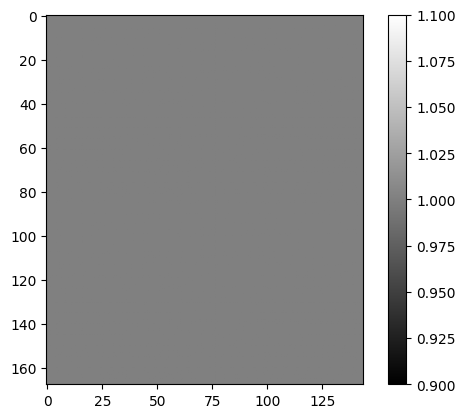

In [7]:
plt.imshow(sea_mask, cmap='gray')
plt.colorbar()

/var/folders/q5/4d_bg8zn7h74dy6rjkx80q4w0000gn/T/ipykernel_21473/3461354129.py:15: RuntimeWarning: Mean of empty slice
  mean_res = np.nanmean(cleanup_clouds_sst[reconstruction_days], axis=0)


RMSE:
 Model: 7.176764965057373
 Mean: 0.7503863573074341
Min: 2.7616636753082275, Max: 35.332035064697266


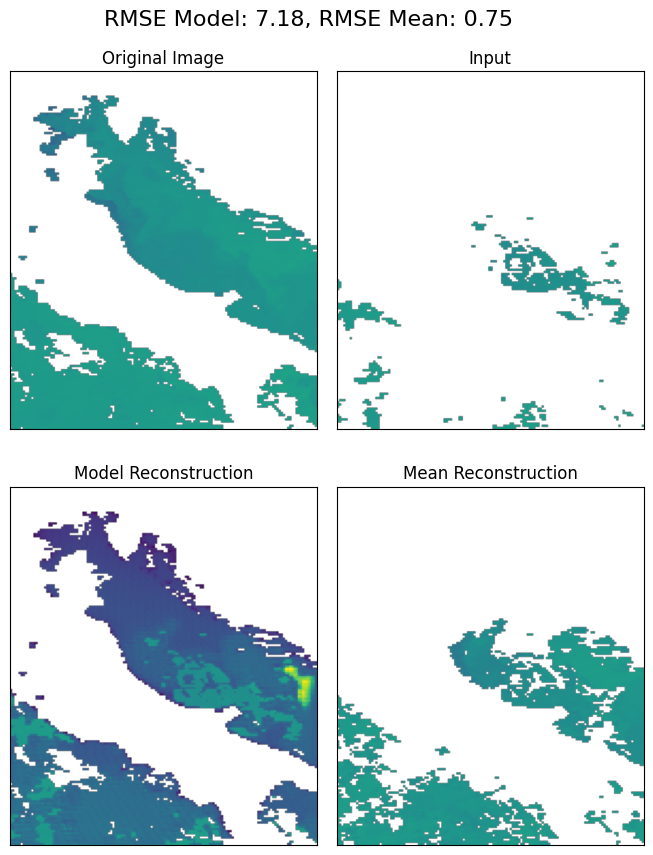

In [17]:
time_window = 3 # Specify the time window for reconstruction
n_days = time_window // 2 # Get the number of days before and after the current day

# for i in added_clouds[0:100]:
    
i = np.random.choice(added_clouds)  # Randomly select a day with added clouds
reconstruction_days = [x for x in range(i - n_days, i + n_days + 1) if x != i]
# The applied clouds are where cleanup_clouds_sst is NaN but and the original image isn't
cloud_mask = np.isnan(cleanup_clouds_sst[i]) & ~np.isnan(cleanup_sst[i])

# Reconstruct the image using the model output where clouds were added and the original image otherwise
reconstructed_img = np.where(cloud_mask, result_sst[i], cleanup_sst[i])

# Calculate the mean of the surrounding days
mean_res = np.nanmean(cleanup_clouds_sst[reconstruction_days], axis=0)
# Calculate the reconstructed image using the mean of the surrounding days where clouds were added
reconstructed_mean_img = np.where(cloud_mask, mean_res, cleanup_sst[i])

# Calculate RMSE between the reconstructed and original images
RMSE_model = np.sqrt(np.nanmean((reconstructed_img - cleanup_sst[i]) ** 2))
RMSE_mean = np.sqrt(np.nanmean((reconstructed_mean_img - cleanup_sst[i]) ** 2))

print(f"RMSE:\n Model: {RMSE_model}\n Mean: {RMSE_mean}")

# Calculate the min and max values for consistent color scaling
vmin = np.min([np.nanmin(reconstructed_img), np.nanmin(cleanup_clouds_sst[i]), np.nanmin(reconstructed_mean_img)])
vmax = np.max([np.nanmax(reconstructed_img), np.nanmax(cleanup_clouds_sst[i]), np.nanmax(reconstructed_mean_img)])
print(f"Min: {vmin}, Max: {vmax}")

fig, axs = plt.subplots(2, 2, figsize=(7, 9), sharex=True, sharey=True)
fig.suptitle(f"RMSE Model: {RMSE_model:.2f}, RMSE Mean: {RMSE_mean:.2f}", fontsize=16)

axs[0, 0].imshow(cleanup_sst[i], cmap='viridis', vmin=vmin, vmax=vmax)
axs[0, 0].set_title('Original Image')

axs[0, 1].imshow(cleanup_clouds_sst[i], cmap='viridis', vmin=vmin, vmax=vmax)
axs[0, 1].set_title('Input')

axs[1, 0].imshow(reconstructed_img, cmap='viridis', vmin=vmin, vmax=vmax)
axs[1, 0].set_title('Model Reconstruction')

axs[1, 1].imshow(reconstructed_mean_img, cmap='viridis', vmin=vmin, vmax=vmax)
axs[1, 1].set_title('Mean Reconstruction')

plt.tight_layout()
for ax in axs.flat:
    ax.set_xticks([])
    ax.set_yticks([])
    # plt.savefig(f"{base_folder}/figs/{i}.png", dpi=300)
    # plt.close()

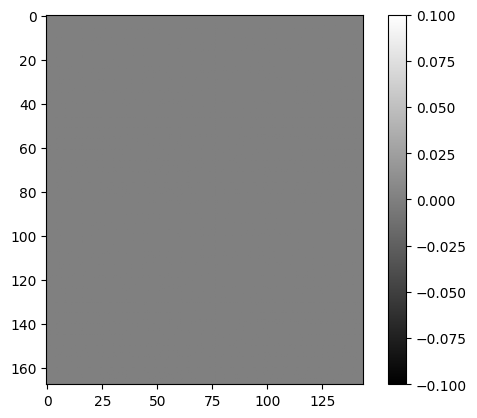

In [9]:
plt.imshow(np.isnan(cleanup_clouds_sst[i]) & ~np.isnan(cleanup_sst[i]), cmap='gray')
plt.colorbar()

In [16]:
cleanup_sst[i].min()

np.float32(0.0)

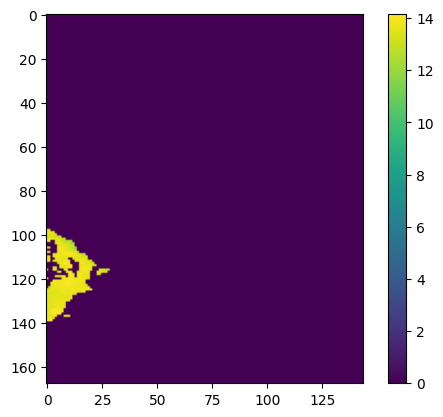

In [15]:
plt.imshow(cleanup_sst[i])
plt.colorbar()

## Calculate mean RMSE

Calculate the mean RMSE of the dataset, using:
- The output of the model
- The mean of the previous and following days

In [10]:
# Calculate where the clouds were applied, only considering water areas
mask = np.isnan(cleanup_clouds_sst) & ~np.isnan(cleanup_sst)

In [11]:
RMSE_rec = []
RMSE_mean = []

for i in range(n_days, N - n_days):
   
    if not mask[i].any(): # If no clouds were applied, skip this iteration
        continue

    diff = (result_sst[i] - cleanup_sst[i])[mask[i]] # Get the difference only where clouds were applied
    if np.isnan(diff).all(): # If all values are NaN, skip this iteration
        continue
    rec = np.sqrt(np.nanmean(diff ** 2)) # Calculate RMSE for reconstruction

    reconstruction_days = [x for x in range(i - n_days, i + n_days + 1) if x != i]
    mean_res = np.nanmean(cleanup_clouds_sst[reconstruction_days], axis=0) # Calculate the mean of the previous and following days
    diff = (mean_res - cleanup_sst[i])[mask[i]] # Get the difference only where clouds were applied
    if np.isnan(diff).all(): # If all values are NaN, skip this iteration
        continue

    mn = np.sqrt(np.nanmean(diff ** 2)) # Calculate RMSE for mean reconstruction

    if np.isnan(rec) or np.isnan(mn):
        print(f"Skipping {i} due to NaN values in RMSE calculations.")
        continue
        
    RMSE_rec.append(rec)
    RMSE_mean.append(mn)

print("Number of valid RMSE values:", len(RMSE_rec))
print("Mean RMSE Reconstruction:", np.mean(RMSE_rec))
print("Mean RMSE Mean:", np.mean(RMSE_mean))


/var/folders/q5/4d_bg8zn7h74dy6rjkx80q4w0000gn/T/ipykernel_21473/4164045493.py:15: RuntimeWarning: Mean of empty slice
  mean_res = np.nanmean(cleanup_clouds_sst[reconstruction_days], axis=0) # Calculate the mean of the previous and following days


Number of valid RMSE values: 434
Mean RMSE Reconstruction: 4.6361575
Mean RMSE Mean: 4.5384297


## Plot the loss

In [12]:
with open(base_folder + 'loss.txt', 'r') as f:
    loss = f.read()
    
loss = loss.split('\n')

loss = [float(x) for x in loss if x]  # Convert to float and remove empty strings

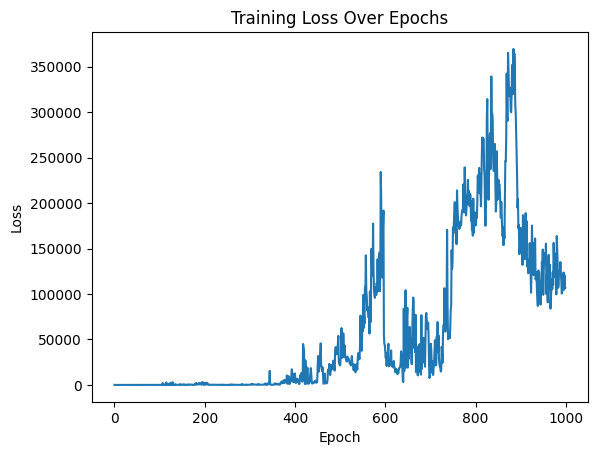

In [13]:
plt.plot(loss)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.show()